# Initial FeO prediction

Start by importing MagmaPEC and MagmaPandas (or regular Pandas)

In [1]:
import MagmaPEC as mpc
import MagmaPandas as mp

Import your melt or whole-rock data

In [2]:
wholerock_file = "./data/wholerock.csv"

wholerock = mp.read_melt(wholerock_file, index_col=["name"])
wholerock.head()

,SiO2,TiO2,Al2O3,MnO,MgO,CaO,Na2O,K2O,P2O5,Cr2O3,FeO,total
name,,,,,,,,,,,,
PI032,46.962818,3.447381,16.650124,0.174618,7.004558,9.400741,3.131253,1.290536,0.635346,0.009630,11.350806,100.057812
PI041,46.292709,3.553973,17.191874,0.170671,6.221699,9.443416,2.701110,1.076079,0.610387,0.007262,10.986336,98.255517
PI053,47.515736,3.084096,15.182294,0.169948,8.250577,9.640357,2.298223,1.013332,0.448063,0.009225,10.955438,98.567288
PI054,47.524357,3.369594,16.456587,0.174671,6.569622,9.216309,2.653994,1.367337,0.648534,0.029540,10.953660,98.964204
PI055,46.452168,3.287018,16.039806,0.169084,7.396060,9.469899,2.035204,1.072211,0.539792,0.011676,10.896147,97.369065


Create the FeOi prediction object and initialise it with your data. Make sure to remove the FeO column from the melt compositions used to predict FeOi. 

In [3]:
x = wholerock.drop(columns=["FeO"])
FeOi_predict = mpc.FeOi_prediction(x=x, FeO=wholerock["FeO"])

Select the columns in *x* that you do not want to use to predict initial FeO contents. Here we do not want to use minor elements and the totals column:

In [4]:
do_not_use = ["MnO", "P2O5", "Cr2O3", "total"]

The *calculate_model_fits* method calculates best-fit multiple linear regressions for all possible combinations of elements in *x*. For each new regression, the element whose removal results in the lowest regression F-test p-value is removed from the dataset.

It returns a dataframe with fitted coefficients and misfit statistics (RMSE, cross-validated RMSE and R<sup>2</sup>). *NaN* values for coefficients indicate that this element has been removed from the calibration dataset and is not used in the regression.

In [5]:
model_fits = FeOi_predict.calculate_model_fits(exclude=do_not_use)
model_fits

,intercept,SiO2,TiO2,Al2O3,MgO,CaO,Na2O,K2O,RMSE,CV-RMSE,deltaRMSE,r2
6,24.162353,-0.184450,1.085716,-0.337465,NaN,-0.292231,0.344686,-0.579578,0.151416,0.278102,0.126686,0.930966
5,21.878478,-0.144730,1.179186,-0.293183,NaN,-0.296750,NaN,-0.300763,0.165387,0.273553,0.108166,0.917640
4,22.442147,-0.168107,1.114827,-0.289476,NaN,-0.260280,NaN,NaN,0.171032,0.232349,0.061317,0.911921
3,11.585125,NaN,1.463365,-0.230722,NaN,-0.169262,NaN,NaN,0.206434,0.237533,0.031100,0.871685
2,9.213242,NaN,1.640962,-0.217524,NaN,NaN,NaN,NaN,0.253769,0.294748,0.040978,0.806092
1,5.357205,NaN,1.725906,NaN,NaN,NaN,NaN,NaN,0.319430,0.355670,0.036240,0.692766


RMSE and R<sup>2</sup> are both calculated on the entire calibration dataset and indicate how good the model is at predicting FeO. For RMSE lower values are better, while for R<sup>2</sup> values close to 1 are best. To check for overfitting, cross-validated RMSE's (CV-RMSE) are also calculated, where large differences between RMSE and CV-RMSE (deltaRMSE) can indicate overfitting issues. As long as RMSE and R<sup>2</sup> values are acceptable, the model with the smallest deltaRMSE should be selected. Here, models 1, 2 and 3 have similar RMSE, deltaRMSE and R<sup>2</sup> values and any of these models would work well for predicting melt FeO contents. In models 4, 5 and 6, deltaRMSE has increased and overfitting might be an issue here.

Next we use the results for the previous step to select our model. Here we use model 3, where TiO<sub>2</sub>, Al<sub>2</sub>O<sub>3</sub> and CaO are used as predictors. In the *select_predictor* method, you pass the index of your preferred model to the *idx* parameter. It shows a plot of the regression and calibration data. Be mindful of the FeO range, and make sure that you do not extrapolate (too much) beyond this range during PEC corrections.

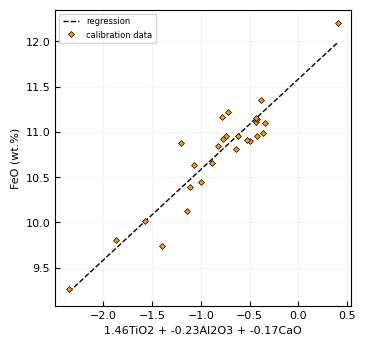

In [6]:
FeOi_predict.select_predictors(idx=3)

We can check if the right predictors are used with the *predictors* attribute

In [7]:
FeOi_predict.predictors

array(['TiO2', 'Al2O3', 'CaO'], dtype=object)

Coefficients of the linear regression were automatically calculated by the *select_predictors* method and we can access these with the *coefficients*, *intercept_error* and *errors* attributes.

Fitted coefficients:

In [8]:
FeOi_predict.coefficients

intercept    11.585125
TiO2          1.463365
Al2O3        -0.230722
CaO          -0.169262
dtype: float64

and their errors as standard deviations:

In [9]:
FeOi_predict.errors

intercept    1.203255
TiO2         0.164396
Al2O3        0.048417
CaO          0.049363
dtype: float64

The *model* attribute stores the selected model as a callable function, which we can use to predict melt FeO contents. The function accepts a pandas DataFrame or MagmaFrame with melt major element compositions in oxide wt. % as input. Let's try that out on the whole-rock data:

In [11]:
model = FeOi_predict.model
model(wholerock)

name
PI032    11.197161
PI041    11.220927
PI053    10.963646
PI054    11.159202
PI055    11.091599
PI056    10.944143
PI057    10.590489
PI058    10.757390
PI060    11.154730
PI063    11.988362
PI065    11.165823
PI066    11.055243
PI067    11.146931
PI068    11.240555
PI069    10.846550
PI070    10.381338
PI071    10.801455
PI074    10.470945
PI077    10.007513
PI078     9.718330
PI079     9.230219
PI081    10.813904
PI084    10.438283
PI094    10.511939
PI097    10.183464
PI111    10.866402
PI114    10.701429
dtype: float32

The *random_sample_coefficients* method randomly samples fitted coefficients within their errors and calculates the matching x-intercept value. This method is used internally in the Monte Carlo PEC correction model to propagate FeOi prediction errors.

In [10]:
FeOi_predict.random_sample_coefficients(n=5)

,TiO2,Al2O3,CaO,intercept
0,1.555664,-0.186890,-0.129272,10.195312
1,1.704102,-0.263428,-0.229004,11.937500
2,1.424805,-0.151489,-0.275146,11.398438
3,1.440430,-0.228882,-0.127197,11.226562
4,1.457031,-0.237793,-0.176147,11.789062
